## Analysis of the temperature offsets
We have conducted an experiment, which studies the impact of the **radiator** network on the **energy consumption** of the S-building. By gradually decreasing the target temperature of the **radiator** network from a normal value (in other words, by performing "offsets"), we get a hypothetical decrease of the **energy consumption**. At the same time, from the empirical values, we see that the **inside temperature** of the rooms do not change, and the values stay within the bounds comfortable for students. Thus, we would like to assess the effect that the offsets cause upon the **energy consumption**.

In [136]:
from rnn import MyGRU, MyLSTM, VanillaRNN, RNN
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [137]:
# Load the downsampled data frame from csv-file.
raw_data = pd.read_csv(r'C:\Users\romat\Documents\GitHub\HAMK_Smart_City\s-building_data.csv')

In [138]:
# Recreate a dataset as if the offsets did not exist. Save indices for the research of the efficiency.
nooffset_data = raw_data.copy()
efficiency_indices = []

def restore_offset(dataset, temperature, start, end = None):
    '''
    Replace radiator temperature values with the values as if the offsets were not applied.
    Inputs: a copy of the dataset where the offsets were implemented, 
    array to which the start of the offset intervals will be appended,
    known temperature offset value as a float,
    date and time when the offset started in format "Y-M-D H:M:S" as string (included),
    date and time when the offset finished in format "Y-M-D H:M:S" as string (excluded).
    '''
    if end != None:
        dataset.loc[(dataset.Time >= start) & (dataset.Time < end), "Radiator_network_1_temperature"] += temperature
        efficiency_indices.append(((dataset.Time >= start) & (dataset.Time < end)).sum())
    else:
        dataset.loc[dataset.Time >= start, "Radiator_network_1_temperature"] += temperature
        efficiency_indices.append((dataset.Time >= start).sum())
        
# Apply the function
restore_offset(nooffset_data, 3, "2022-01-13 12:00:00", "2022-01-20 11:00:00")
restore_offset(nooffset_data, 4, "2022-01-20 11:00:00", "2022-01-28 09:00:00")
restore_offset(nooffset_data, 5, "2022-01-28 09:00:00", "2022-02-08 11:00:00")
restore_offset(nooffset_data, 6, "2022-02-08 11:00:00")

In [139]:
# Initialize the model with the required parameters. Create an extra model object to make the preprocessing work properly.
hvac_model = MyGRU(quant=['Energy_consumption'], seq=12, fut=0, parameters=['District_heat_temperature',
        "Floor_network_2_temperature", "Domestic_water_network_1_primary_valve", "CO2_concentration",
       'Domestic_water_network_1_temperature', 'Energy_consumption',
       'Radiator_network_1_temperature',
       'Ventilation_network_1_temperature', 'Outside_temperature_average',
       'Outside_humidity', 'Solar_irradiance'])

hvac_model_1 = MyGRU(quant=['Energy_consumption'], seq=12, fut=0, parameters=['District_heat_temperature',
        "Floor_network_2_temperature", "Domestic_water_network_1_primary_valve", "CO2_concentration",
       'Domestic_water_network_1_temperature', 'Energy_consumption',
       'Radiator_network_1_temperature',
       'Ventilation_network_1_temperature', 'Outside_temperature_average',
       'Outside_humidity', 'Solar_irradiance'])
              
            
# Scale, split, and sequence the downsampled data frame.
x_train, y_train, x_test, y_test = hvac_model.preprocess(raw_data)

# Scale, split, and sequence the dataset without the offset data. It is not required for training, just for the future inference.
no_x_train, no_y_train, no_x_test, no_y_test = hvac_model_1.preprocess(nooffset_data)

Shape of training data: (1316, 12, 11)
Shape of testing data: (320, 12, 11)
Shape of training data: (1316, 12, 11)
Shape of testing data: (320, 12, 11)


In [101]:
# Train the model using custom fit method. 
# Does hyperparameter optimization automatically in pre-defined search space. Comment row below, if you have already trained the model.
hvac_model.fit(X=x_train, y=y_train, epochs=1000, max_trials=15)
hvac_model.save()

Trial 15 Complete [00h 01m 49s]
val_loss: 0.008649610493739602

Best val_loss So Far: 0.008649610493739602
Total elapsed time: 00h 22m 40s
INFO:tensorflow:Oracle triggered exit
Results summary
Results in C:\Users\romat\Documents\GitHub\HAMK_Smart_City\GRU_Energy_consumption_2022-03-27
Showing 15 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
units: 60
layers: 1
activation function: tanh
learning rate: 0.001
Score: 0.008649610493739602
Trial summary
Hyperparameters:
units: 60
layers: 1
activation function: tanh
learning rate: 0.001
Score: 0.008893349058052991
Trial summary
Hyperparameters:
units: 30
layers: 1
activation function: tanh
learning rate: 0.001
Score: 0.00897401979600545
Trial summary
Hyperparameters:
units: 40
layers: 1
activation function: tanh
learning rate: 0.01
Score: 0.009062766865827142
Trial summary
Hyperparameters:
units: 40
layers: 1
activation function: tanh
learning rate: 0.001
Score: 0.00909376741910819
Trial summary
Hyperp

In [140]:
# Load the weights, scaler and other variables
hvac_model.load(r'C:\Users\romat\Documents\GitHub\HAMK_Smart_City\GRU_Energy_consumption_2022-03-27')

Model loaded.
Scaler loaded.
Other variables loaded.


In [141]:
# Predictions for the data with offsets
train_preds = hvac_model.model.predict(x_train)
test_preds = hvac_model.model.predict(x_test)

# Predictions for the data without the offsets
no_train_preds = hvac_model.model.predict(no_x_train)
no_test_preds = hvac_model.model.predict(no_x_test)

# Inverse target variables both for measured values and computed predictions.
inv_preds_train, inv_y_train = hvac_model.inv_target(x_train, train_preds, y_train)
inv_preds_test, inv_y_test = hvac_model.inv_target(x_test, test_preds, y_test)

# Inverse target variables both for measured values and computed predictions for the data without offsets
inv_no_preds_train, inv_no_y_train = hvac_model.inv_target(no_x_train, no_train_preds, no_y_train)
inv_no_preds_test, inv_no_y_test = hvac_model.inv_target(no_x_test, no_test_preds, no_y_test)

# Plot model predictions against measurements
hvac_model.plot_preds(inv_preds_train, inv_y_train)

In [143]:
def offset_efficiencies():
    '''
    Function for calculating efficiency gains in particular offsets
    Output: a list of efficiency gains in the particular offset separated by predefined offset indices
    '''
    efficiencies = []
    efficiency_indices = efficiency_indices[::-1]
    division = inv_no_preds_train / inv_preds_train
    efficiencies.append((division)[-efficiency_indices[0]:].mean())
    for i in range(len(efficiency_indices) - 1):
        efficiencies.append((division)[-(sum(efficiency_indices[:(i+2)])):-(sum(efficiency_indices[:(i+1)]))].mean())
        print((division)[-(sum(efficiency_indices[:(i+2)])):-(sum(efficiency_indices[:(i+1)]))].mean())
    assert len(efficiency_indices) == len(efficiencies), "Indices and efficiencies array have different length"
    efficiencies = efficiencies[::-1]
    efficiencies = np.array(efficiencies)
    efficiencies = efficiencies * 100 - 100
    return efficiencies

Text(0.5, 1.0, 'Energy consumption with and without radiator network offsets')

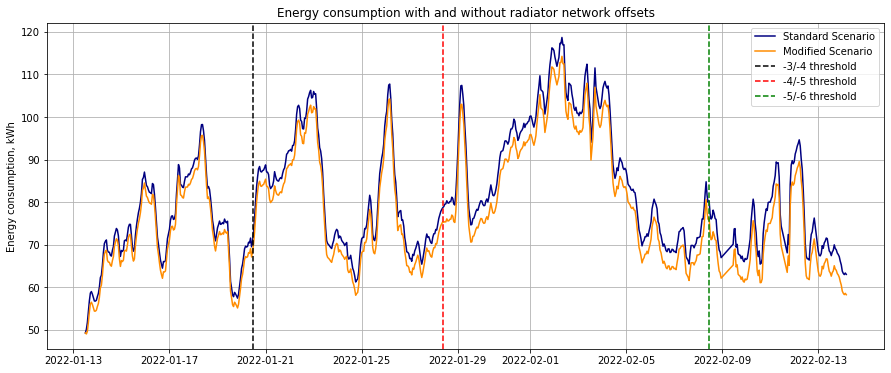

In [145]:
# Select the timeframe when the network was subjected to offsets
y1 = raw_data["Radiator_network_1_temperature"].iloc[-(np.sum(efficiency_indices)):]
y2 = nooffset_data["Radiator_network_1_temperature"].iloc[-(np.sum(efficiency_indices)):]
x = raw_data["Time"].iloc[-(np.sum(efficiency_indices)):]

# Plot energy consumption between different offsets
plt.figure(figsize=(15, 6))
plt.plot(x, inv_no_preds_train[-(np.sum(future_indexes)):], color='navy', label='Standard Scenario')
plt.plot(x, inv_preds_train[-(np.sum(future_indexes)):], color='darkorange', label='Modified Scenario')

# Manually add threshold lines
plt.axvline(x = mdates.date2num(datetime.datetime(2022, 1, 20, 11, 0)), ls = "--", c = "black", label="-3/-4 threshold")
plt.axvline(x = mdates.date2num(datetime.datetime(2022, 1, 28, 9, 0)), ls = "--", c = "red", label="-4/-5 threshold")
plt.axvline(x = mdates.date2num(datetime.datetime(2022, 2, 8, 11, 0)), ls = "--", c = "green", label="-5/-6 threshold")
plt.legend()
plt.grid()
plt.ylabel("Energy consumption, kWh")
plt.title("Energy consumption with and without radiator network offsets")

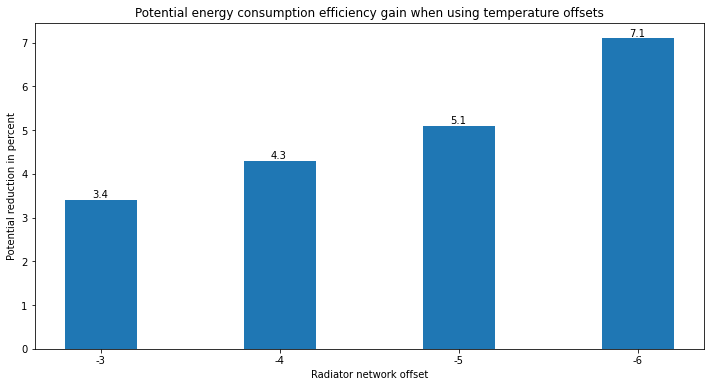

In [146]:
# Create barplots with energy efficiency gains in the particular offsets
plt.figure(figsize=(12, 6))
plt.bar(offsets, efficiencies.round(1), width = 0.4)
plt.title('Potential energy consumption efficiency gain when using temperature offsets')
plt.ylabel("Potential reduction in percent")
plt.xlabel("Radiator network offset")
xlocs, xlabs = plt.xticks()
# Change the range depending on the number of thresholds
xlocs=[i for i in range(0,4)]
for i, v in enumerate(efficiencies.round(1)):
    plt.text(xlocs[i] - 0.05, v + 0.05, str(v))
plt.show()

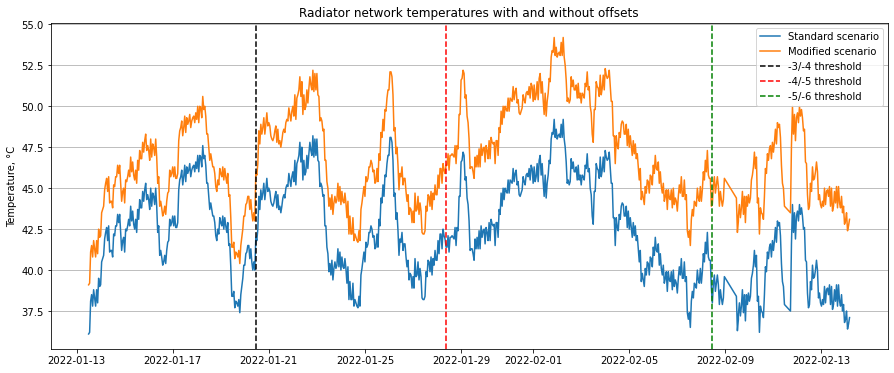

In [147]:
# Plot the measured and the offset-scenario radiator network temperatures
plt.figure(figsize = (15, 6))
plt.plot(x, y1, label = "Standard scenario")
plt.plot(x, y2, label = "Modified scenario")

# Manually add the threshold lines
plt.axvline(x = mdates.date2num(datetime.datetime(2022, 1, 20, 11, 0)), ls = "--", c = "black", label="-3/-4 threshold")
plt.axvline(x = mdates.date2num(datetime.datetime(2022, 1, 28, 9, 0)), ls = "--", c = "red", label="-4/-5 threshold")
plt.axvline(x = mdates.date2num(datetime.datetime(2022, 2, 8, 11, 0)), ls = "--", c = "green", label="-5/-6 threshold")
plt.title("Radiator network temperatures with and without offsets")
plt.ylabel("Temperature, °C")
plt.legend()
plt.grid(axis = "y")
plt.show()